# Data Rebalancing - Minority Class Augmentation

**Obiettivo:** Ribilanciare il training set aggiungendo campioni della classe minoritaria (TruePositive) dal GUIDE_Test.csv

**Pipeline:**
1. Analisi distribuzione classi nel training set attuale
2. Caricamento GUIDE_Test.csv
3. Applicazione stesso preprocessing di Test_03 - FeatureEngineering_v3
4. Estrazione campioni classe minoritaria dal test set
5. Merge con training set originale
6. Verifica bilanciamento finale
7. Salvataggio nuovo dataset bilanciato

## 1. Setup e Analisi Training Set Attuale

In [26]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import os
import warnings
warnings.filterwarnings('ignore')

print("Librerie importate con successo!")

Librerie importate con successo!


In [27]:
# Carica training set attuale
X_train_orig = pd.read_csv('../data/processed_v3/X_train.csv')
y_train_orig = pd.read_csv('../data/processed_v3/y_train.csv')

print(f"Training set originale: {X_train_orig.shape}")
print(f"\nDistribuzione classi:")
print(y_train_orig['BinaryIncidentGrade'].value_counts())
print(f"\nPercentuali:")
print(y_train_orig['BinaryIncidentGrade'].value_counts(normalize=True).mul(100).round(2))

# Calcola quanti campioni servono per bilanciare
class_counts = y_train_orig['BinaryIncidentGrade'].value_counts()
majority_count = class_counts[0]
minority_count = class_counts[1]
samples_needed = majority_count - minority_count

print(f"\nClasse maggioritaria (0): {majority_count:,} campioni")
print(f"Classe minoritaria (1): {minority_count:,} campioni")
print(f"Campioni necessari per bilanciamento completo: {samples_needed:,}")

Training set originale: (314230, 43)

Distribuzione classi:
BinaryIncidentGrade
0    247302
1     66928
Name: count, dtype: int64

Percentuali:
BinaryIncidentGrade
0    78.7
1    21.3
Name: proportion, dtype: float64

Classe maggioritaria (0): 247,302 campioni
Classe minoritaria (1): 66,928 campioni
Campioni necessari per bilanciamento completo: 180,374


## 2. Caricamento e Preprocessing GUIDE_Test

Applichiamo lo stesso preprocessing di Test_03 - FeatureEngineering_v3

In [28]:
# Carica GUIDE_Test.csv
print("Caricamento GUIDE_Test.csv...")
df_test = pd.read_csv('../data/GUIDE_Test.csv')

print(f"Dataset test caricato: {df_test.shape[0]:,} righe, {df_test.shape[1]} colonne")

# Rimuovi record senza target
df_test = df_test[df_test['IncidentGrade'].notna()].copy()

print(f"Dimensioni dopo pulizia: {df_test.shape}")

Caricamento GUIDE_Test.csv...
Dataset test caricato: 4,147,992 righe, 46 colonne
Dimensioni dopo pulizia: (4147992, 46)


### 2.1 Target Binario

In [29]:
# Crea target binario: 1 = TruePositive, 0 = FalsePositive/BenignPositive
df_test['BinaryIncidentGrade'] = df_test['IncidentGrade'].apply(
    lambda x: 1 if x == 'TruePositive' else 0
)

counts = df_test['BinaryIncidentGrade'].value_counts()
percentages = df_test['BinaryIncidentGrade'].value_counts(normalize=True).mul(100).round(2)

result = pd.DataFrame({'Count': counts, 'Percentage': percentages})
print("\nDistribuzione Target Binario nel Test Set:")
print(result)

# Verifica se ci sono abbastanza campioni TruePositive
tp_available = counts.get(1, 0)
print(f"\nCampioni TruePositive disponibili: {tp_available:,}")
print(f"Campioni TruePositive necessari: {samples_needed:,}")

if tp_available >= samples_needed:
    print(f"✓ Abbiamo abbastanza campioni per bilanciamento completo!")
else:
    print(f"⚠ Possiamo aggiungere solo {tp_available:,} campioni (bilanciamento parziale)")


Distribuzione Target Binario nel Test Set:
                       Count  Percentage
BinaryIncidentGrade                     
0                    2655638       64.02
1                    1492354       35.98

Campioni TruePositive disponibili: 1,492,354
Campioni TruePositive necessari: 180,374
✓ Abbiamo abbastanza campioni per bilanciamento completo!


### 2.2 SmoothedRisk per AlertTitle

In [30]:
# IMPORTANTE: Dobbiamo usare le statistiche del TRAINING set per calcolare SmoothedRisk
# altrimenti creiamo data leakage

# Carica il training originale per calcolare le statistiche globali
df_train_full = pd.read_csv('../data/GUIDE_Train.csv')
df_train_full = df_train_full[df_train_full['IncidentGrade'].notna()].copy()
df_train_full['BinaryIncidentGrade'] = df_train_full['IncidentGrade'].apply(
    lambda x: 1 if x == 'TruePositive' else 0
)

# Calcola risk dal training set
alert_risk = df_train_full.groupby('AlertTitle')['BinaryIncidentGrade'].mean()
alert_count = df_train_full.groupby('AlertTitle')['BinaryIncidentGrade'].sum()

alert_summary = pd.DataFrame({
    'Risk': alert_risk,
    'Count': alert_count
})

# Bayesian smoothing
alpha = 2
beta = 2

alert_summary['SmoothedRisk'] = (
    alert_summary['Risk'] * alert_summary['Count'] + alpha
) / (alert_summary['Count'] + alpha + beta)

# Applica al test set
df_test = df_test.merge(
    alert_summary[['SmoothedRisk']], 
    left_on='AlertTitle', 
    right_index=True, 
    how='left'
)

# Fill NaN per AlertTitle non visti nel training con media globale
global_mean = alert_summary['SmoothedRisk'].mean()
df_test['SmoothedRisk'] = df_test['SmoothedRisk'].fillna(global_mean)

print(f"SmoothedRisk applicato al test set")
print(f"Statistiche SmoothedRisk:")
print(df_test['SmoothedRisk'].describe())

# Libera memoria
del df_train_full

SmoothedRisk applicato al test set
Statistiche SmoothedRisk:
count    4.147992e+06
mean     4.910405e-01
std      2.671985e-01
min      1.622586e-02
25%      2.835467e-01
50%      5.000000e-01
75%      7.540790e-01
max      9.999631e-01
Name: SmoothedRisk, dtype: float64


### 2.3 GeoLoc_freq

In [31]:
# Crea identificatore geografico
df_test['GeoLoc'] = (
    df_test['CountryCode'].astype(str) + "_" + 
    df_test['State'].astype(str) + "_" + 
    df_test['City'].astype(str)
)

# Calcola frequenza normalizzata
geo_freq = df_test['GeoLoc'].value_counts(normalize=True)
df_test['GeoLoc_freq'] = df_test['GeoLoc'].map(geo_freq)

# Drop colonne geografiche originali
df_test.drop(columns=['CountryCode', 'State', 'City', 'GeoLoc'], inplace=True)

print("GeoLoc_freq creato")
print(df_test['GeoLoc_freq'].describe())

GeoLoc_freq creato
count    4.147992e+06
mean     8.371064e-01
std      2.547715e-01
min      2.410805e-07
25%      9.148381e-01
50%      9.148381e-01
75%      9.148381e-01
max      9.148381e-01
Name: GeoLoc_freq, dtype: float64


### 2.4 Features Temporali

In [32]:
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])
df_test['month'] = df_test['Timestamp'].dt.month
df_test['hour'] = df_test['Timestamp'].dt.hour
df_test['weekday'] = df_test['Timestamp'].dt.weekday + 1
df_test['IsWeekend'] = (df_test['Timestamp'].dt.dayofweek >= 5).astype(int)

print("Features temporali create: month, hour, weekday, IsWeekend")

Features temporali create: month, hour, weekday, IsWeekend


### 2.5 Gestione Missing e Frequency Encoding

In [33]:
# Fill missing values
df_test['Roles'] = df_test['Roles'].fillna('missing')
df_test['ActionGrouped'] = df_test['ActionGrouped'].fillna('Missing')
df_test['SuspicionLevel'] = df_test['SuspicionLevel'].fillna('Missing')
df_test['LastVerdict'] = df_test['LastVerdict'].fillna('Missing')

# Group rare verdicts (< 100 occorrenze)
verdict_counts = df_test['LastVerdict'].value_counts()
rare_verdicts = verdict_counts[verdict_counts < 100].index
df_test['LastVerdict'] = df_test['LastVerdict'].replace(rare_verdicts, 'Other')

print("Missing values gestiti")

Missing values gestiti


In [34]:
# Frequency encoding per colonne ad alta cardinalità
freq_encode_cols = [
    'ThreatFamily', 'AntispamDirection', 'ActionGranular',
    'LastVerdict', 'ResourceType', 'Roles', 'ActionGrouped', 
    'EntityType', 'Category'
]

for col in freq_encode_cols:
    if col in df_test.columns:
        # Fill missing
        df_test[col] = df_test[col].fillna('Missing')
        
        # Frequency encode
        freq = df_test[col].value_counts(normalize=True)
        df_test[f"{col}_freq"] = df_test[col].map(freq)
        
        # Drop original
        df_test.drop(columns=col, inplace=True)
        print(f"  {col} -> {col}_freq")

print(f"\nFrequency encoding completato per {len(freq_encode_cols)} colonne")

  ThreatFamily -> ThreatFamily_freq
  AntispamDirection -> AntispamDirection_freq
  ActionGranular -> ActionGranular_freq
  LastVerdict -> LastVerdict_freq
  ResourceType -> ResourceType_freq
  Roles -> Roles_freq
  ActionGrouped -> ActionGrouped_freq
  EntityType -> EntityType_freq
  Category -> Category_freq

Frequency encoding completato per 9 colonne


### 2.6 One-Hot Encoding Selettivo

In [35]:
onehot_cols = ['SuspicionLevel', 'EvidenceRole']

for col in onehot_cols:
    if col in df_test.columns:
        # Fill missing
        df_test[col] = df_test[col].fillna('Missing')
        
        # Group rare categories (< 100 occorrenze)
        counts = df_test[col].value_counts()
        rare = counts[counts < 100].index
        df_test[col] = df_test[col].replace(rare, 'Other')
        
        # One-hot encode (drop_first per evitare multicollinearità)
        df_test = pd.get_dummies(df_test, columns=[col], drop_first=True)
        print(f"  {col} -> one-hot encoded")

print("\nOne-hot encoding completato")

  SuspicionLevel -> one-hot encoded
  EvidenceRole -> one-hot encoded

One-hot encoding completato


### 2.7 Processing MITRE Techniques (Top 30)

In [36]:
# Step 1: Split semicolon-separated string
df_test['MitreList'] = df_test['MitreTechniques'].apply(
    lambda x: x.split(';') if pd.notna(x) else []
)

# Step 2: Usa le stesse top 30 tecniche del training set
# Dobbiamo ricaricare il training per identificare le top 30 tecniche
df_train_mitre = pd.read_csv('../data/GUIDE_Train.csv', usecols=['MitreTechniques'])
df_train_mitre['MitreList'] = df_train_mitre['MitreTechniques'].apply(
    lambda x: x.split(';') if pd.notna(x) else []
)
all_techs_train = [tech for sublist in df_train_mitre['MitreList'] for tech in sublist]
top_techs = [tech for tech, _ in Counter(all_techs_train).most_common(30)]
top_tech_set = set(top_techs)

print(f"Top 30 MITRE techniques dal training set:")
print(f"Top 10: {Counter(all_techs_train).most_common(10)}")

# Libera memoria
del df_train_mitre, all_techs_train

Top 30 MITRE techniques dal training set:
Top 10: [('T1078', 1469659), ('T1078.004', 1357816), ('T1566.002', 815784), ('T1566', 663278), ('T1110', 189475), ('T1133', 177415), ('T1566.001', 140569), ('T1110.003', 108948), ('T1110.001', 107551), ('T1071', 96351)]


In [37]:
# Step 3: Filtra ogni lista per includere solo top techniques
df_test['FilteredMitreList'] = df_test['MitreList'].apply(
    lambda x: [tech for tech in x if tech in top_tech_set]
)

# Step 4: One-hot encode con MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=top_techs)
tech_matrix = pd.DataFrame(
    mlb.fit_transform(df_test['FilteredMitreList']),
    columns=mlb.classes_, 
    index=df_test.index
)

# Step 5: Merge e drop colonne originali
df_test = pd.concat([df_test, tech_matrix], axis=1)
df_test.drop(columns=['MitreTechniques', 'MitreList', 'FilteredMitreList'], inplace=True)

print(f"\nMITRE features create: {tech_matrix.shape[1]}")
print(f"Shape dataset test: {df_test.shape}")


MITRE features create: 30
Shape dataset test: (4147992, 80)


### 2.8 Aggregazione a Livello Incident

In [38]:
def get_mode(x):
    mode = x.mode()
    return mode[0] if len(mode) > 0 else x.iloc[0] if len(x) > 0 else None

# Prepara aggregazioni
agg_dict = {
    'BinaryIncidentGrade': 'first',
    'IncidentGrade': 'first',
    'AlertId': 'nunique',
    'Id': 'count',
    'SmoothedRisk': 'mean',
    'GeoLoc_freq': 'mean',
    'hour': ['min', 'max', 'mean'],
    'month': get_mode,
    'weekday': get_mode,
    'IsWeekend': 'max',
    'Timestamp': ['min', 'max'],
}

# Aggiungi frequency-encoded columns (media)
freq_cols = [col for col in df_test.columns if col.endswith('_freq') and col not in ['GeoLoc_freq']]
for col in freq_cols:
    agg_dict[col] = 'mean'

# Aggiungi one-hot encoded columns (somma)
onehot_cols_created = [col for col in df_test.columns if col.startswith(('SuspicionLevel_', 'EvidenceRole_'))]
for col in onehot_cols_created:
    agg_dict[col] = 'sum'

# Aggiungi MITRE columns (somma)
mitre_cols = [col for col in df_test.columns if col.startswith('T') and len(col) <= 6]
for col in mitre_cols:
    agg_dict[col] = 'sum'

print(f"Aggregazioni preparate per {len(agg_dict)} features")

Aggregazioni preparate per 43 features


In [39]:
# Esegui aggregazione
incident_test = df_test.groupby('IncidentId').agg(agg_dict).reset_index()

# Flatten colonne multi-livello
incident_test.columns = [
    '_'.join(col).strip('_') if isinstance(col, tuple) else col 
    for col in incident_test.columns.values
]

print(f"Dataset test aggregato: {incident_test.shape}")

Dataset test aggregato: (236267, 47)


In [40]:
# Calcola durata e rinomina colonne
incident_test['Duration_seconds'] = (
    pd.to_datetime(incident_test['Timestamp_max']) - 
    pd.to_datetime(incident_test['Timestamp_min'])
).dt.total_seconds()

rename_map = {
    'AlertId_nunique': 'NumAlerts',
    'Id_count': 'NumEvidences',
    'SmoothedRisk_mean': 'SmoothedRisk_avg',
    'GeoLoc_freq_mean': 'GeoLoc_freq_avg',
    'hour_min': 'Hour_First',
    'hour_max': 'Hour_Last',
    'hour_mean': 'Hour_Avg',
    'BinaryIncidentGrade_first': 'BinaryIncidentGrade',
    'IncidentGrade_first': 'IncidentGrade',
}

incident_test = incident_test.rename(columns=rename_map)
incident_test = incident_test.drop(columns=['Timestamp_min', 'Timestamp_max'], errors='ignore')

print(f"Features finali test set: {incident_test.shape[1] - 3}")  # -3 per ID e 2 target

Features finali test set: 43


## 3. Estrazione Campioni Classe Minoritaria

In [41]:
# Filtra solo TruePositive (classe 1) dal test set processato
tp_samples = incident_test[incident_test['BinaryIncidentGrade'] == 1].copy()

print(f"Campioni TruePositive disponibili nel test set: {len(tp_samples):,}")
print(f"Campioni necessari per bilanciamento: {samples_needed:,}")

# Determina quanti campioni aggiungere
samples_to_add = min(len(tp_samples), samples_needed)

print(f"\nCampioni che aggiungeremo: {samples_to_add:,}")

# Sample casuale se abbiamo più campioni del necessario
if len(tp_samples) > samples_needed:
    tp_samples_selected = tp_samples.sample(n=samples_needed, random_state=42)
    print(f"Campionamento casuale di {samples_needed:,} TruePositive")
else:
    tp_samples_selected = tp_samples
    print(f"Utilizzo di tutti i {len(tp_samples):,} TruePositive disponibili")

Campioni TruePositive disponibili nel test set: 49,554
Campioni necessari per bilanciamento: 180,374

Campioni che aggiungeremo: 49,554
Utilizzo di tutti i 49,554 TruePositive disponibili


## 4. Merge con Training Set Originale

In [42]:
# Ricostruisci incident_agg dal training originale
incident_train = pd.read_csv('../data/processed_v3/incident_features.csv')

print(f"Training set originale (incident level): {incident_train.shape}")

# Verifica che le colonne siano allineate
train_cols = set(incident_train.columns)
test_cols = set(tp_samples_selected.columns)

missing_in_test = train_cols - test_cols
missing_in_train = test_cols - train_cols

if missing_in_test:
    print(f"\n⚠ Colonne nel training ma non nel test: {missing_in_test}")
    # Aggiungi colonne mancanti con valore 0
    for col in missing_in_test:
        tp_samples_selected[col] = 0

if missing_in_train:
    print(f"\n⚠ Colonne nel test ma non nel training: {missing_in_train}")
    # Aggiungi colonne mancanti con valore 0
    for col in missing_in_train:
        incident_train[col] = 0

# Allinea ordine colonne
tp_samples_selected = tp_samples_selected[incident_train.columns]

print(f"\nColonne allineate: {incident_train.shape[1]}")

Training set originale (incident level): (448901, 46)

Colonne allineate: 46


In [43]:
# Concatena training originale + nuovi campioni TruePositive
incident_balanced = pd.concat([incident_train, tp_samples_selected], axis=0, ignore_index=True)

print(f"\nDataset bilanciato: {incident_balanced.shape}")
print(f"Campioni aggiunti: {len(tp_samples_selected):,}")
print(f"\nNuova distribuzione classi:")
print(incident_balanced['BinaryIncidentGrade'].value_counts())
print(f"\nPercentuali:")
print(incident_balanced['BinaryIncidentGrade'].value_counts(normalize=True).mul(100).round(2))


Dataset bilanciato: (498455, 46)
Campioni aggiunti: 49,554

Nuova distribuzione classi:
BinaryIncidentGrade
0    353289
1    145166
Name: count, dtype: int64

Percentuali:
BinaryIncidentGrade
0    70.88
1    29.12
Name: proportion, dtype: float64


## 5. Preparazione Dataset per Modeling

In [44]:
# Separa features e target
X_balanced = incident_balanced.drop(columns=['IncidentId', 'BinaryIncidentGrade', 'IncidentGrade'])
y_balanced = incident_balanced['BinaryIncidentGrade']

# Gestisci missing (se presenti)
X_balanced = X_balanced.fillna(-999)

print(f"Features finali: {X_balanced.shape}")
print(f"Target: {y_balanced.shape}")
print(f"\nDistribuzione target:")
print(y_balanced.value_counts())
print(f"\nPercentuali:")
print(y_balanced.value_counts(normalize=True).mul(100).round(2))

Features finali: (498455, 43)
Target: (498455,)

Distribuzione target:
BinaryIncidentGrade
0    353289
1    145166
Name: count, dtype: int64

Percentuali:
BinaryIncidentGrade
0    70.88
1    29.12
Name: proportion, dtype: float64


## 6. Split Train/Test Stratificato del Nuovo Dataset

In [45]:
from sklearn.model_selection import train_test_split

# Split stratificato (70/30)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)

print(f"X_train_balanced: {X_train_bal.shape}")
print(f"X_test_balanced: {X_test_bal.shape}")
print(f"\nDistribuzione y_train_balanced:")
print(y_train_bal.value_counts())
print(y_train_bal.value_counts(normalize=True).mul(100).round(2))
print(f"\nDistribuzione y_test_balanced:")
print(y_test_bal.value_counts())
print(y_test_bal.value_counts(normalize=True).mul(100).round(2))

X_train_balanced: (348918, 43)
X_test_balanced: (149537, 43)

Distribuzione y_train_balanced:
BinaryIncidentGrade
0    247302
1    101616
Name: count, dtype: int64
BinaryIncidentGrade
0    70.88
1    29.12
Name: proportion, dtype: float64

Distribuzione y_test_balanced:
BinaryIncidentGrade
0    105987
1     43550
Name: count, dtype: int64
BinaryIncidentGrade
0    70.88
1    29.12
Name: proportion, dtype: float64


## 7. Salvataggio Dataset Bilanciato

In [46]:
# Crea directory per dataset bilanciato
os.makedirs('../data/processed_v3_balanced', exist_ok=True)

# Salva dataset bilanciato
X_train_bal.to_csv('../data/processed_v3_balanced/X_train.csv', index=False)
X_test_bal.to_csv('../data/processed_v3_balanced/X_test.csv', index=False)
y_train_bal.to_csv('../data/processed_v3_balanced/y_train.csv', index=False, header=['BinaryIncidentGrade'])
y_test_bal.to_csv('../data/processed_v3_balanced/y_test.csv', index=False, header=['BinaryIncidentGrade'])

# Salva anche il dataframe completo aggregato
incident_balanced.to_csv('../data/processed_v3_balanced/incident_features.csv', index=False)

print("Dataset bilanciato salvato in ../data/processed_v3_balanced/")
print(f"  - X_train.csv: {X_train_bal.shape}")
print(f"  - X_test.csv: {X_test_bal.shape}")
print(f"  - y_train.csv: {y_train_bal.shape}")
print(f"  - y_test.csv: {y_test_bal.shape}")
print(f"  - incident_features.csv: {incident_balanced.shape}")

Dataset bilanciato salvato in ../data/processed_v3_balanced/
  - X_train.csv: (348918, 43)
  - X_test.csv: (149537, 43)
  - y_train.csv: (348918,)
  - y_test.csv: (149537,)
  - incident_features.csv: (498455, 46)


## 8. Confronto Distribuzioni

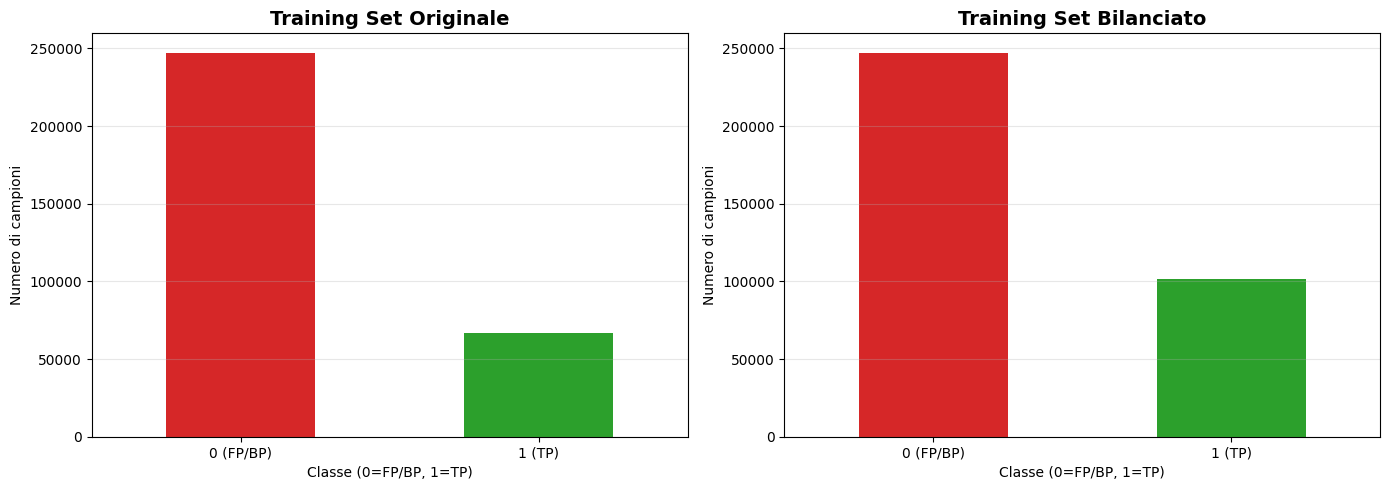

Grafico salvato in ../models/class_distribution_comparison.png


In [47]:
import matplotlib.pyplot as plt

# Crea confronto visivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training originale
y_train_orig['BinaryIncidentGrade'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=['#d62728', '#2ca02c']
)
axes[0].set_title('Training Set Originale', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe (0=FP/BP, 1=TP)')
axes[0].set_ylabel('Numero di campioni')
axes[0].set_xticklabels(['0 (FP/BP)', '1 (TP)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Training bilanciato
y_train_bal.value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color=['#d62728', '#2ca02c']
)
axes[1].set_title('Training Set Bilanciato', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe (0=FP/BP, 1=TP)')
axes[1].set_ylabel('Numero di campioni')
axes[1].set_xticklabels(['0 (FP/BP)', '1 (TP)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../models/class_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Grafico salvato in ../models/class_distribution_comparison.png")

In [48]:
# Stampa statistiche finali
print("=" * 60)
print("RIEPILOGO BILANCIAMENTO")
print("=" * 60)

orig_counts = y_train_orig['BinaryIncidentGrade'].value_counts()
bal_counts = y_train_bal.value_counts()

print(f"\nTraining Originale:")
print(f"  Classe 0 (FP/BP): {orig_counts[0]:,} ({orig_counts[0]/len(y_train_orig)*100:.2f}%)")
print(f"  Classe 1 (TP):    {orig_counts[1]:,} ({orig_counts[1]/len(y_train_orig)*100:.2f}%)")
print(f"  Totale:           {len(y_train_orig):,}")
print(f"  Imbalance ratio:  {orig_counts[0]/orig_counts[1]:.2f}:1")

print(f"\nTraining Bilanciato:")
print(f"  Classe 0 (FP/BP): {bal_counts[0]:,} ({bal_counts[0]/len(y_train_bal)*100:.2f}%)")
print(f"  Classe 1 (TP):    {bal_counts[1]:,} ({bal_counts[1]/len(y_train_bal)*100:.2f}%)")
print(f"  Totale:           {len(y_train_bal):,}")
print(f"  Imbalance ratio:  {bal_counts[0]/bal_counts[1]:.2f}:1")

print(f"\nCampioni aggiunti:  {bal_counts[1] - orig_counts[1]:,}")
print(f"Incremento classe minoritaria: {((bal_counts[1] - orig_counts[1]) / orig_counts[1] * 100):.2f}%")
print("=" * 60)

RIEPILOGO BILANCIAMENTO

Training Originale:
  Classe 0 (FP/BP): 247,302 (78.70%)
  Classe 1 (TP):    66,928 (21.30%)
  Totale:           314,230
  Imbalance ratio:  3.70:1

Training Bilanciato:
  Classe 0 (FP/BP): 247,302 (70.88%)
  Classe 1 (TP):    101,616 (29.12%)
  Totale:           348,918
  Imbalance ratio:  2.43:1

Campioni aggiunti:  34,688
Incremento classe minoritaria: 51.83%


## Summary

**Obiettivo raggiunto:**
- ✓ Preprocessing identico a Test_03 - FeatureEngineering_v3 applicato a GUIDE_Test
- ✓ Campioni TruePositive estratti dal test set
- ✓ Training set bilanciato creato
- ✓ Split stratificato 70/30 mantenuto
- ✓ Dataset salvato in `../data/processed_v3_balanced/`

**Prossimi passi:**
1. Addestrare XGBoost sul nuovo dataset bilanciato
2. Confrontare performance con modello su dataset originale
3. Valutare se il bilanciamento migliora recall sulla classe minoritaria

**Note importanti:**
- SmoothedRisk calcolato da statistiche training per evitare data leakage
- Top 30 MITRE techniques dal training set usate per test set
- Colonne allineate tra training e test per garantire compatibilità